In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import sklearn.metrics as metrics
from scipy.stats import randint, uniform
import pickle
from xgboost import XGBClassifier

# Load Dataset

In [2]:
df = pd.read_csv('dataset_phishing.csv')

# Data Cleaning and Preprocessing

In [3]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [5]:
df.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [6]:
df['status'].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

In [7]:
#change status into int dtype with legitimate as 0 and phishing as 1
mapping = {'legitimate':0, 'phishing':1}

df['status'] = df['status'].map(mapping)

In [8]:
df['status'].value_counts()

status
0    5715
1    5715
Name: count, dtype: int64

In [9]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
length_url,1.000000,0.223025,0.453961,0.443589,0.399564,0.150739,0.520930,0.576268,NaN,0.621745,...,0.125159,-0.006476,-0.007082,0.002799,-0.006798,0.072205,0.023357,0.236395,-0.102582,0.248580
length_hostname,0.223025,1.000000,0.252013,0.408956,0.057702,0.071793,0.162400,0.145617,NaN,0.183405,...,0.217284,0.074707,-0.097794,-0.041081,0.013854,0.163238,-0.023344,0.213990,-0.159342,0.238322
ip,0.453961,0.252013,1.000000,0.288398,0.109860,0.059401,0.405434,0.383262,NaN,0.440972,...,0.137716,0.014561,0.053246,-0.108869,-0.077020,0.167930,0.127823,0.270743,-0.218968,0.321698
nb_dots,0.443589,0.408956,0.288398,1.000000,0.045099,0.263283,0.347411,0.435798,NaN,0.414902,...,0.107789,0.055560,0.056407,-0.024117,-0.007818,0.087969,0.126659,0.209616,-0.097312,0.207029
nb_hyphens,0.399564,0.057702,0.109860,0.045099,1.000000,0.018770,0.036804,0.120487,NaN,0.107050,...,0.006909,0.020297,-0.055794,0.038163,0.080104,-0.041464,-0.031477,-0.018828,0.104341,-0.100107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
web_traffic,0.072205,0.163238,0.167930,0.087969,-0.041464,-0.009459,0.143777,0.164797,NaN,0.187809,...,0.081786,0.083888,0.022598,-0.110435,-0.096698,1.000000,-0.007113,0.034099,-0.209526,0.060388
dns_record,0.023357,-0.023344,0.127823,0.126659,-0.031477,0.031611,0.009441,0.076372,NaN,0.052159,...,0.062084,0.043817,0.213899,-0.060811,-0.068023,-0.007113,1.000000,0.096413,-0.142135,0.122119
google_index,0.236395,0.213990,0.270743,0.209616,-0.018828,0.113217,0.201260,0.129093,NaN,0.167385,...,0.267465,-0.143655,0.040633,-0.134656,-0.210111,0.034099,0.096413,1.000000,-0.389887,0.731171
page_rank,-0.102582,-0.159342,-0.218968,-0.097312,0.104341,-0.066356,-0.123852,-0.126164,NaN,-0.133089,...,-0.330810,0.058843,-0.155990,0.345751,0.589602,-0.209526,-0.142135,-0.389887,1.000000,-0.511137


In [10]:
target_corr = corr_matrix['status']
target_corr

length_url         0.248580
length_hostname    0.238322
ip                 0.321698
nb_dots            0.207029
nb_hyphens        -0.100107
                     ...   
web_traffic        0.060388
dns_record         0.122119
google_index       0.731171
page_rank         -0.511137
status             1.000000
Name: status, Length: 88, dtype: float64

In [11]:
#only choose features with abs value > 0.1

threshold=0.1
relevant_features = target_corr[abs(target_corr)>threshold].index.tolist()
relevant_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_eq',
 'nb_slash',
 'nb_semicolumn',
 'nb_www',
 'nb_com',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'shortening_service',
 'length_words_raw',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extRedirection',
 'external_favicon',
 'links_in_tags',
 'ratio_intMedia',
 'ratio_extMedia',
 'safe_anchor',
 'empty_title',
 'domain_in_title',
 'domain_with_copyright',
 'domain_registration_length',
 'domain_age',
 'dns_record',
 'google_index',
 'page_rank',
 'status']

In [12]:
#only select relevant features

X = df[relevant_features]
X = X.drop('status', axis=1)
y = df['status']

In [13]:
X.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_slash,...,ratio_extMedia,safe_anchor,empty_title,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,3,...,0.000000,0.0,0,0,1,45,-1,1,1,4
1,77,23,1,1,0,0,0,0,0,5,...,20.000000,100.0,0,1,0,77,5767,0,1,2
2,126,50,1,4,1,0,1,2,3,5,...,0.000000,100.0,0,1,0,14,4004,0,1,0
3,18,11,0,2,0,0,0,0,0,2,...,3.571429,62.5,0,1,0,62,-1,0,0,3
4,55,15,0,2,2,0,0,0,0,5,...,100.000000,0.0,0,0,1,224,8175,0,0,6


In [14]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: status, dtype: int64

# Model Development

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()

In [17]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Random Forest

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled,y_train)

RandomForestClassifier()

In [50]:
rf_predict = rf.predict(X_test_scaled)

In [51]:
accuracy = accuracy_score(y_test,rf_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:97%


In [52]:
rf_Accuracy_Score = accuracy_score(y_test,rf_predict)
rf_JaccardIndex = jaccard_score(y_test,rf_predict)
rf_F1_Score = f1_score(y_test,rf_predict)
rf_Log_Loss = log_loss(y_test,rf_predict)

In [53]:
print(f"Accuracy: {rf_Accuracy_Score}")
print(f"Jaccard Index: {rf_JaccardIndex}")
print(f"F1 Score: {rf_F1_Score}")
print(f"Log Loss: {rf_Log_Loss}")

Accuracy: 0.9650043744531933
Jaccard Index: 0.9312123817712812
F1 Score: 0.9643811219946572
Log Loss: 1.2613701973444325


In [54]:
rf_conf_matrix = confusion_matrix(y_test,rf_predict)
rf_conf_matrix

array([[1123,   34],
       [  46, 1083]], dtype=int64)

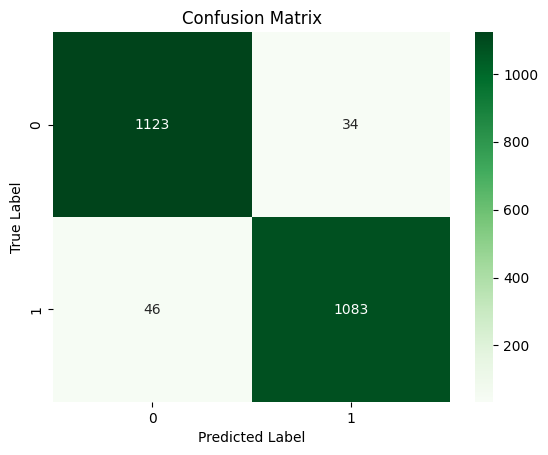

In [55]:
sns.heatmap(rf_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [56]:
rf_report = classification_report(y_test,rf_predict)
print(rf_report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1157
           1       0.97      0.96      0.96      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.96      0.96      2286
weighted avg       0.97      0.97      0.97      2286



In [26]:
svm = SVC()
svm.fit(X_train_scaled,y_train)

SVC()

In [27]:
svm_predict = svm.predict(X_test_scaled)

In [28]:
accuracy = accuracy_score(y_test,svm_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:97%


In [29]:
svm_Accuracy_Score = accuracy_score(y_test,svm_predict)
svm_JaccardIndex = jaccard_score(y_test,svm_predict)
svm_F1_Score = f1_score(y_test,svm_predict)
svm_Log_Loss = log_loss(y_test,svm_predict)

In [30]:
print(f"Accuracy: {svm_Accuracy_Score}")
print(f"Jaccard Index: {svm_JaccardIndex}")
print(f"F1 Score: {svm_F1_Score}")
print(f"Log Loss: {svm_Log_Loss}")

Accuracy: 0.9654418197725284
Jaccard Index: 0.9321888412017167
F1 Score: 0.9649044868947134
Log Loss: 1.245603069877627


In [31]:
svm_conf_matrix = confusion_matrix(y_test,svm_predict)
svm_conf_matrix

array([[1121,   36],
       [  43, 1086]], dtype=int64)

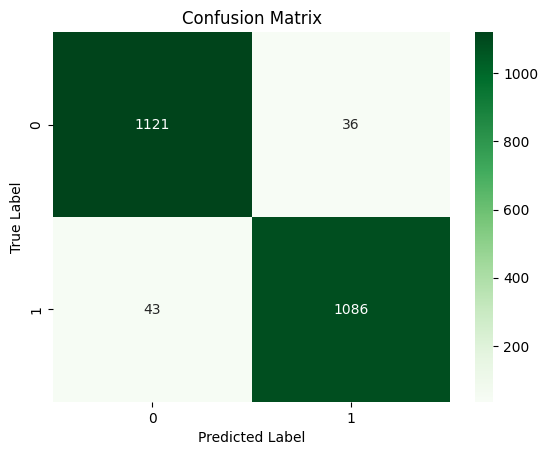

In [32]:
sns.heatmap(svm_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## XGBoost

In [33]:
params = {
    'n_estimators': 100,
    'max_depth': 6,       
    'learning_rate': 0.1,
    'subsample': 0.8,     
    'colsample_bytree': 0.8, 
    'min_child_weight': 1,    
    'gamma': 0,                
    'objective': 'binary:logistic'
}

In [34]:
xgb = XGBClassifier(**params)
xgb.fit(X_train_scaled,y_train)

c:\Users\saidi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
xgb_predict = xgb.predict(X_test_scaled)

In [36]:
accuracy = accuracy_score(y_test,xgb_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:97%


In [37]:
xgb_Accuracy_Score = accuracy_score(y_test,xgb_predict)
xgb_JaccardIndex = jaccard_score(y_test,xgb_predict)
xgb_F1_Score = f1_score(y_test,xgb_predict)
xgb_Log_Loss = log_loss(y_test,xgb_predict)

In [38]:
print(f"Accuracy: {xgb_Accuracy_Score}")
print(f"Jaccard Index: {xgb_JaccardIndex}")
print(f"F1 Score: {xgb_F1_Score}")
print(f"Log Loss: {xgb_Log_Loss}")

Accuracy: 0.968066491688539
Jaccard Index: 0.9372852233676976
F1 Score: 0.9676274944567628
Log Loss: 1.1510003050767947


In [39]:
xgb_conf_matrix = confusion_matrix(y_test,xgb_predict)
xgb_conf_matrix

array([[1122,   35],
       [  38, 1091]], dtype=int64)

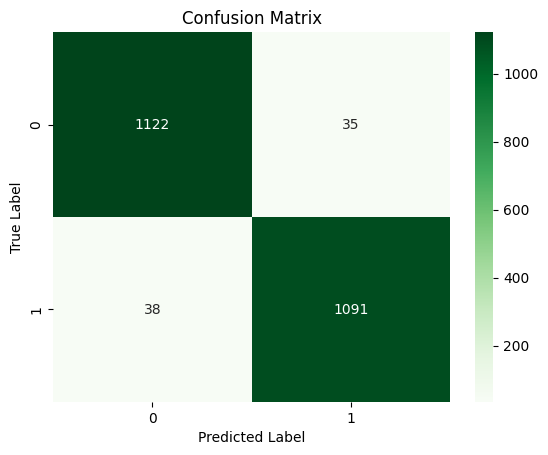

In [ ]:
sns.heatmap(xgb_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Model Accurancy

In [41]:
accuracy_scores = {
    'Random Forest' : round(accuracy_score(y_test,rf_predict), 2),
    'SVM' : round(accuracy_score(y_test,svm_predict), 2),
    'XGBoost' : round(accuracy_score(y_test,xgb_predict), 2)
}

In [42]:
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy Score'])
accuracy_df

,Model,Accuracy Score
0,Random Forest,0.97
1,SVM,0.97
2,XGBoost,0.97


## Saving the Model

In [43]:
#saving the best performing model

#filename = 'phishing_detection_model.pkl'
#pickle.dump(rf, open(filename, 'wb'))

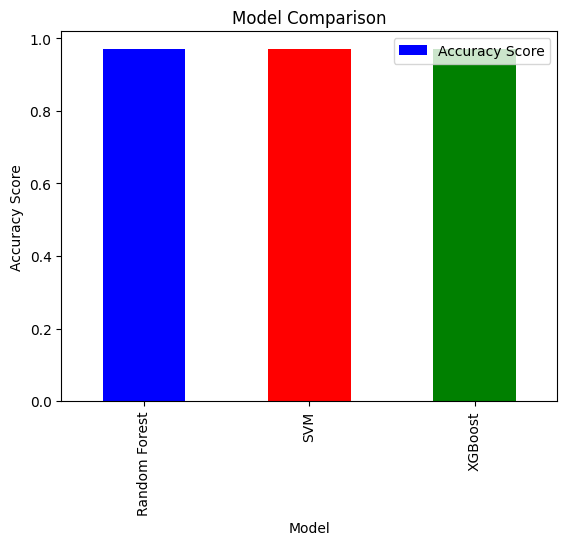

In [44]:
#models comparison bar plot with different colors
accuracy_df.plot(x='Model', y='Accuracy Score', kind='bar', color=['blue', 'red', 'green'])
plt.title('Model Comparison')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.legend()
plt.show()

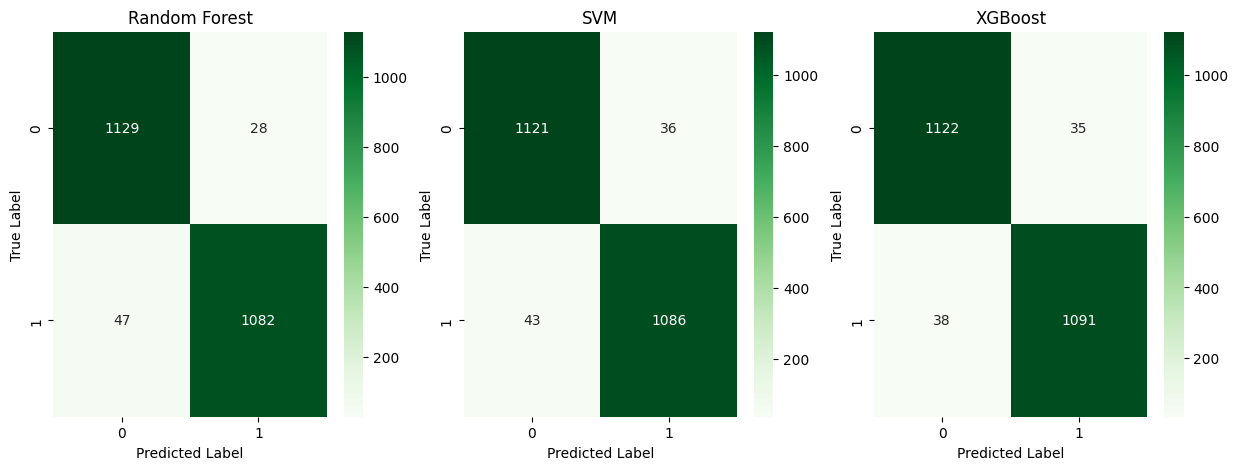

In [45]:
#show all confusion matrices in one plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.heatmap(rf_conf_matrix,annot=True, fmt = 'd',cmap='Greens', ax=ax[0])
ax[0].set_title('Random Forest')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')
sns.heatmap(svm_conf_matrix,annot=True, fmt = 'd',cmap='Greens', ax=ax[1])
ax[1].set_title('SVM')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
sns.heatmap(xgb_conf_matrix,annot=True, fmt = 'd',cmap='Greens', ax=ax[2])
ax[2].set_title('XGBoost')
ax[2].set_xlabel('Predicted Label')
ax[2].set_ylabel('True Label')
plt.show()

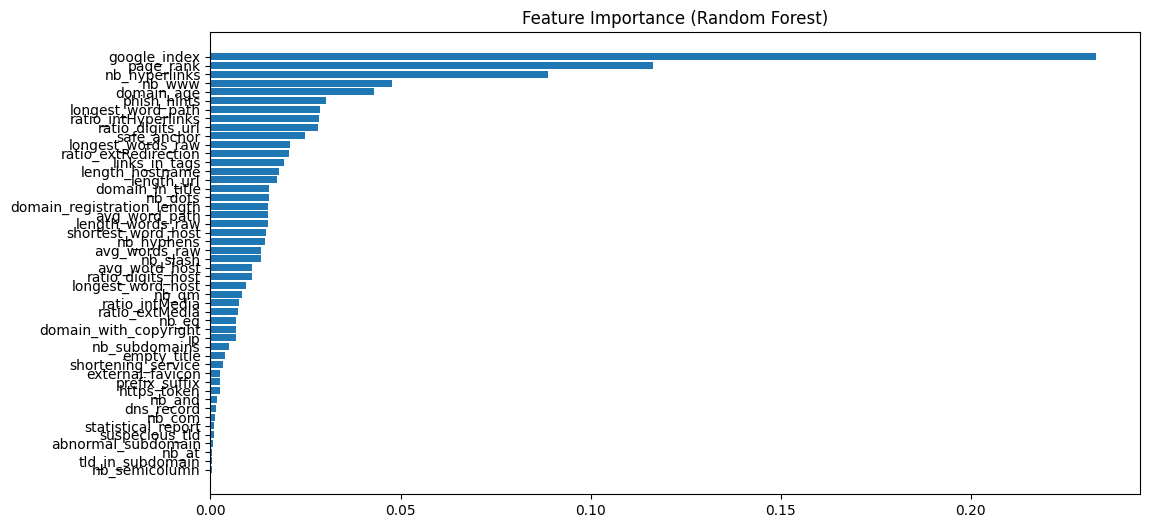

In [46]:
#feature importance plot for Random Forest
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance (Random Forest)')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.show()

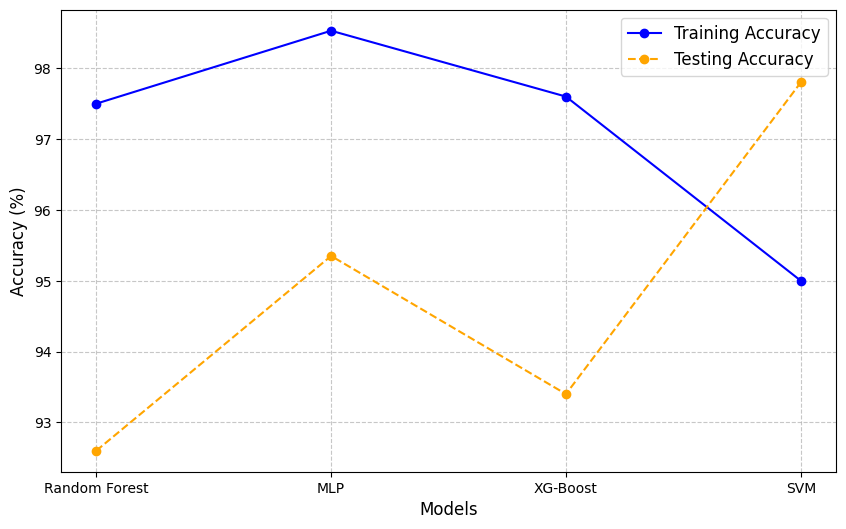

In [47]:
import matplotlib.pyplot as plt

# Model names
models = ['Random Forest', 'MLP', 'XG-Boost', 'SVM']

# Training and testing accuracies
training_accuracies = [97.5, 98.53, 97.6, 95.0]
testing_accuracies = [92.6, 95.35, 93.4, 97.8]

# Plotting the accuracies
plt.figure(figsize=(10, 6))

# Plot training accuracies
plt.plot(models, training_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')

# Plot testing accuracies
plt.plot(models, testing_accuracies, marker='o', linestyle='--', color='orange', label='Testing Accuracy')

# Adding labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.show()